## 1. Dask DataFrame

Please note that not all Pandas API functions are implemented by Dask. When we need some older functions that may be deprecated but still operational, a warning message will appear. We can simply suppress these warning messages by executing the cell below.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### 1.1 Analyzing and working with datasets

In this part of the tutorial, we will utilize the flights data from New York City Airport covering the years 1990 to 1999. The zip file has been uploaded to Blackboard. Please unzip the folder and upload it to Colab or place it in the appropriate location for access.



Please note that Dask has not yet loaded the data. It has:
- Analyzed the input path and identified ten matching files
- Created a set of jobs for each chunk, specifically one for each original CSV file in this instance.

**The representation of the `DataFrame` object contains no data**
- Dask has only read the beginning of the first file to infer the column names and data types.
  - The function `dask.dataframe.read_csv` reads only a sample from the start of the file.
- We assume that all files will have the same set of column names and data types. These inferred data types are enforced when reading all partitions.

In this case, some of the inferred data types from the sample may be incorrect.

When this occurs, we can specify the data types directly using the `dtype` keyword.

In [3]:
import dask.dataframe as dd
ddf = dd.read_csv('data/*.csv', parse_dates={"Date": [0,1,2]}, dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'str',  "Cancelled": bool})

**Lazy Evaluation**

Most Dask Collections, including Dask DataFrame, are evaluated lazily. This means that Dask constructs the logic for your computation, known as a task graph immediately but "evaluates" them only when necessary.

Certain functions will trigger computation (requesting data), such as `len`, `head`, `tail`, and others.

When the `len` function is called, Dask will:
- Load the actual data by importing each file into a pandas DataFrame.
- Apply the function to each pandas DataFrame.
- Combine the subtotals to provide the final count of records.

In [4]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,<NA>,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,<NA>,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,<NA>,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,<NA>,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,<NA>,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [5]:
# Let's load and count the number of rows in the files
len(ddf)

2611892

In [6]:
ddf.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


#### 1.2 Data Processing with dask.dataframe

First, let's calculate the maximum delay in departure times across all flight records.

Using Pandas, we need to iterate through each file to determine the maximum delay for each one. After that, we can compare the maximum delays from all files to compute the final result.

In [15]:
%%time
import os
import pandas as pd
files = os.listdir('./data')
maximum_delays = []
for file in files:
    if file.endswith('.csv'):
      df = pd.read_csv('./data/' + file)
      maximum_delays.append(df['DepDelay'].max())
result = max(maximum_delays)

print(result)

1435.0
CPU times: total: 3.8 s
Wall time: 3.89 s


Dask DataFrame allows us to write code similar to Pandas that can process datasets larger than memory in parallel.

In [16]:
%%time
result = ddf['DepDelay'].max()
result.compute()

CPU times: total: 14.8 s
Wall time: 11.1 s


1435.0

Keep in mind that Dask will remove intermediate results as soon as possible. This allows us to work with datasets larger than memory.

However, repeated computations will require loading all the data each time.

Let's compare the running times for both versions.

In this section, let's explore data processing using `dask.dataframe`.

If you're familiar with Pandas, this should feel quite similar.

You'll need to consider when it's appropriate to call `compute()`.

In [ ]:
#TODO 1: Investigate how many flights were taken that were not canceled.

2540961

In [ ]:
#TODO 2: Show the count of non-canceled flights originating from each airport.

,Origin
Origin,
EWR,1139451
JFK,427243
LGA,974267


In [ ]:
#TODO 3: Calculate the average departure delay for each airport.

,DepDelay
Origin,
EWR,10.295469
JFK,10.351299
LGA,7.431142


In [ ]:
#TODO 4: Determine which day of the week experiences the highest average departure delay.

np.int64(5)

In [ ]:
#TODO 5: Given that the distance column is problematic,
#        how can we add 10 to each value in that column?

,Distance
0,329.0
1,329.0
2,329.0
3,329.0
4,329.0
...,...
269176,1629.0
269177,1629.0
269178,1629.0
269179,1629.0


#### 1.3 Sharing Intermediate Results

In certain scenarios, we may need to perform the same operation multiple times. For most operations, `dask.dataframe` stores the arguments, enabling shared execution of duplicate computations, which means they only run once.

For instance, let’s calculate the mean and standard deviation of departure delays for all non-canceled flights.

Since Dask operations are executed lazily, these values are not final results; they merely represent the steps needed to obtain the outcome.

If you invoke two compute calls, the intermediate computations will not be shared.

In [17]:
#  compute with two calls to compute

non_cancelled_flights = ddf[~ddf['Cancelled']]
mean_delay = non_cancelled_flights['DepDelay'].mean()
std_delay = non_cancelled_flights['DepDelay'].std()

In [18]:
%%time
mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

CPU times: total: 30 s
Wall time: 22.2 s


Let's try to using single compute call both functions

In [19]:
%%time
import dask
mean_delay_result, std_delay_result = dask.compute(mean_delay, std_delay)

CPU times: total: 17 s
Wall time: 12.8 s


If you are using Jupyter Notebook on your own computer, you can utilize the dask.visualize function to analyze the merged task graphs from multiple results and identify common elements. However, it appears that Colab does not permit us to visualize this computation.

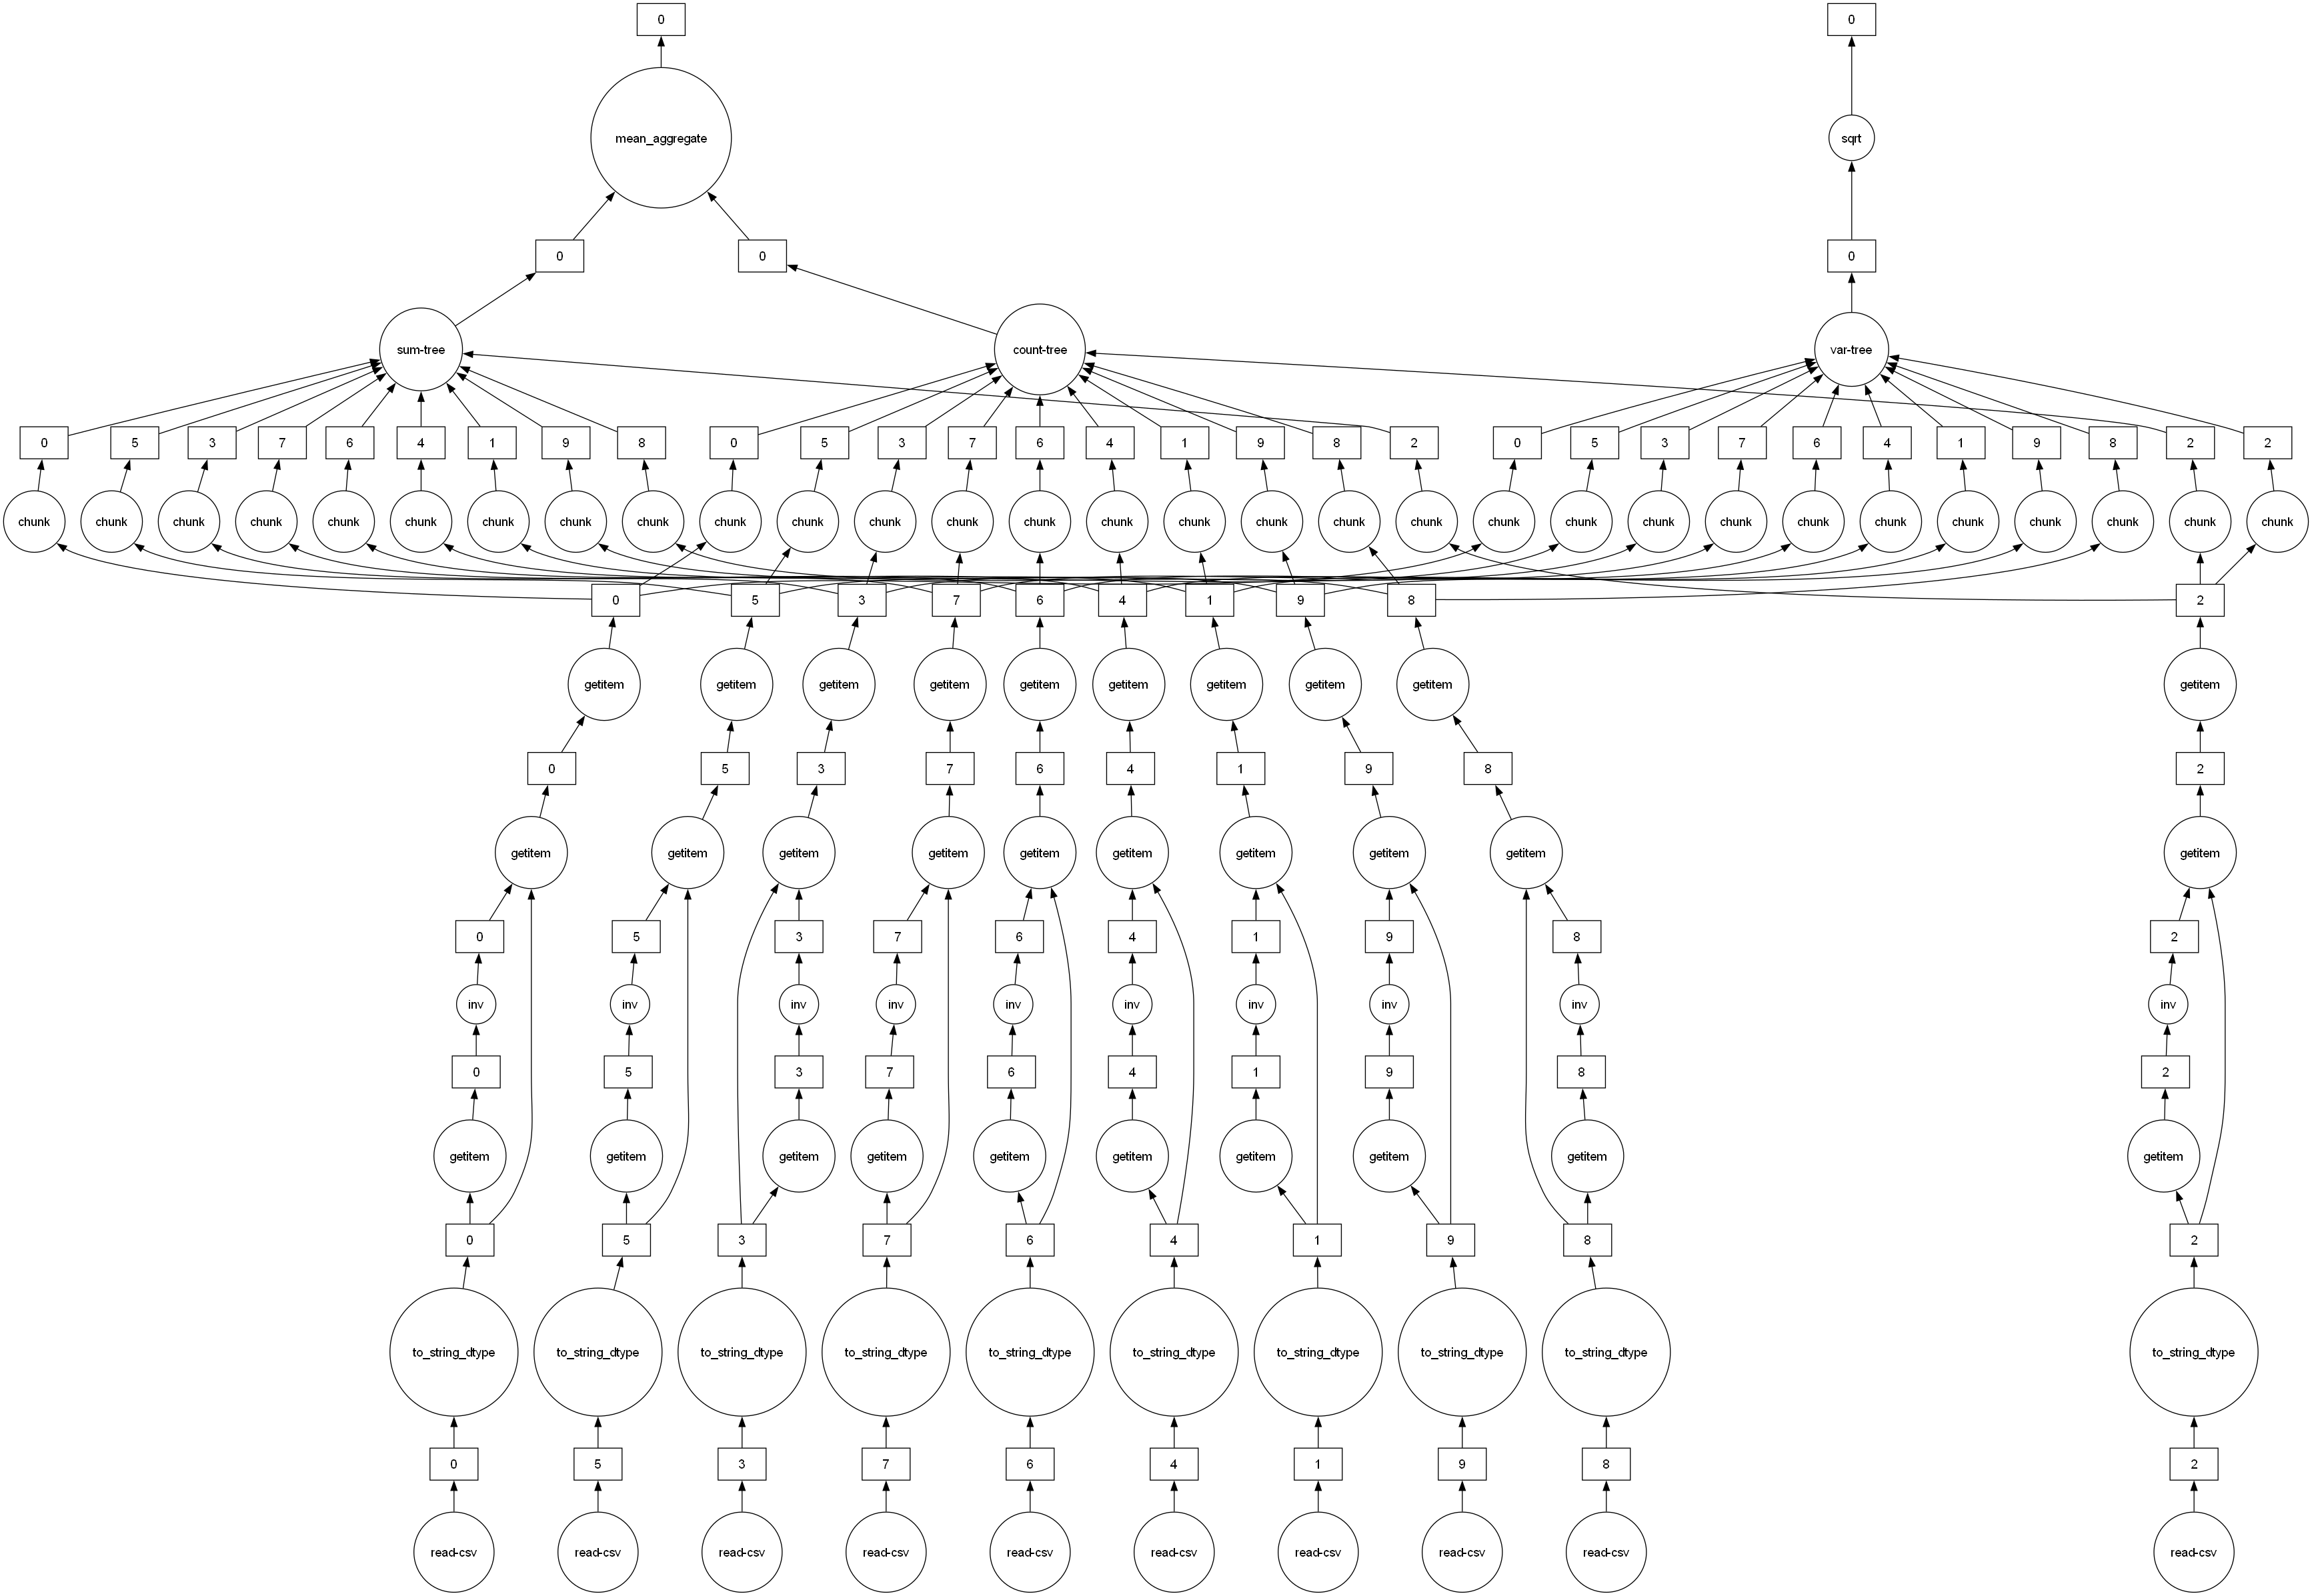

In [20]:
# dask.visualize(mean_delay, std_delay)
mean_delay
std_delay
dask.visualize(mean_delay, std_delay)

#### 1.4 persist function: store the result in cache

With a distributed scheduler, frequently accessed data can be stored in distributed memory.  

The `persist()` function produces outputs and organizes them in the same structure as your results. You can apply `persist()` to any data or computation that fits within memory.  

To analyze data on non-canceled flights departing from JFK airport, you can use two compute calls, as shown in the earlier section.

In [21]:
non_cancelled_flights = ddf[~ddf['Cancelled']]
ddf_jfk = non_cancelled_flights[non_cancelled_flights['Origin'] == "JFK"]

In [22]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

CPU times: total: 30.3 s
Wall time: 22.4 s


np.float64(31.242509798271147)

Now, we consider persisting the subset of data in the memory

In [23]:
ddf_jfk = ddf_jfk.persist()

In [24]:
%%time
ddf_jfk.DepDelay.mean().compute()
ddf_jfk.DepDelay.std().compute()

CPU times: total: 46.9 ms
Wall time: 45.1 ms


np.float64(31.242509798271147)

Persisted data is faster because we avoid repeating the loading and selection operations for non-canceled flights departing from JFK.

## 2. Spark Setup

Install Required Library

Everytime you use the Python engine provided by Google Cloud, you need to install all the libraries to run the code.

In [ ]:
!pip install pyspark

#### 2.1 Create SparkContext and SparkSession

Before examining examples, let's first set up the SparkSession and SparkContext using the builder pattern method specified in the SparkSession class. During this initialization, we must specify the master and application name as demonstrated below.

In [ ]:
from pyspark.sql import SparkSession

ss  = SparkSession.builder \
                            .master("local[1]")\
                            .appName("SparkByExamples.com")\
                            .getOrCreate()
spark = ss.sparkContext

1. SparkSession.builder:    
This initiates the process of creating a SparkSession.

2. `.master("local[1]")`:        
Sets the master name for the Spark application.
"local[1]" means that Spark will run locally with one thread. This is useful for development and testing purposes, allowing you to run Spark on your local machine without needing a cluster.

    - Use `local[x]` when running in Standalone mode (i.e., local machine). `x` should be an integer value and should be greater than 0; this represents how many partitions it should create when using RDD, DataFrame, and Dataset. Ideally, `x` value should be the number of CPU cores you have.

3. `.appName("SparkByExamples.com")`:     
Assigns a name to the Spark application.
"SparkByExamples.com" is just an example name; you can choose any name that helps identify your application.

4. `.getOrCreate()`:     
Either retrieves an existing SparkSession or creates a new one if none exists.
It ensures that you **don't accidentally create multiple sessions**, which can lead to resource management issues.

5. `spark = ss.sparkContext`:      
Retrieves the SparkContext from the SparkSession.
The SparkContext is the primary entry point for Spark functionality and is responsible for coordinating the execution of tasks across the cluster (or in this case, locally).

#### 2.2 SparkContext

SparkContext is a main entry point for Spark functionality. A SparkContext represents the connection to a Spark cluster, and can be used to create RDDs, accumlators and broadcast variables on that cluster.

Here, we will try to get the setting in the current SparkContext.

In [ ]:
spark.getConf().getAll()

[('spark.app.name', 'SparkByExamples.com'),
 ('spark.app.id', 'local-1757651882592'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.executor

When running operations on Pyspark, there will be many log giving the information of different ops. We can adjust the log level to control the information displayed. By default, the log level is warn in Pyspark. The log level in Pyspark is:


|  Log Levels   | Meanings  |
|  ----  | ----  |
| DEBUG  | The DEBUG Level designates fine-grained infomration events that are most useful to debug an application |
| INFO  | The INFO level designates infomrational messages that highlights the progresss of the application at coarse-grained level. |
| WARN  | The WARN level designates potentially harmful situations. |
| ERROR  | The ERROR level designates error events that might still allow the application to continue running. |
| TRACE  | The TRACE Level designates finer-grained informational events than the DEBUG. |
| FATAL  | The FATAL Level designates very severe error events that will presumably lead the application to abort. |
| ALL  | The ALL Level has the lowest possible rank and is intended to turn on all logging. |
| OFF  | The OFF Level has the highest possible rank and is intended to turn off logging. |

If you can run the following code, that means the Pyspark is running. Let's run a simple program to do a letter count.

In [ ]:
from pyspark import SparkContext
from operator import add

data = spark.parallelize(list("Hello World"))
data.collect()
counts = data.map(lambda x:
	(x, 1)).reduceByKey(add).sortBy(lambda x: x[1],
	 ascending=False).collect()

for (word, count) in counts:
    print("{}: {}".format(word, count))

l: 3
o: 2
H: 1
e: 1
 : 1
W: 1
r: 1
d: 1


Find all k-mers with count greater than 1 that are palindromes.

## 3: Spark Programming Examples

### 3.1 Create RDD
`pyspark.SparkContext` creates a client which connects to a Spark cluster. This client can be used to create an RDD object. There are two methods from this class for directly creating RDD objects:
* `parallelize()`
* `textFile()`

### 3.1.1 `parallelize()` distribute a local **python collection** to form an RDD. Common built-in python collections include `dist`, `list`, `tuple` or `set`.

**Important**: Use `collect()` to get back the value in RDD

In [ ]:
# from a list
rdd_data = spark.parallelize([1,2,3])
rdd_data

ParallelCollectionRDD[6] at readRDDFromFile at PythonRDD.scala:289

In [ ]:
rdd_data.collect()

[1, 2, 3]

In [ ]:
# from a tuple
rdd_data = spark.parallelize(('cat', 'dog', 'fish'))
rdd_data.collect()

['cat', 'dog', 'fish']

In [ ]:
# from a list of tuple
list_t = [('cat', 'dog', 'fish'), ('orange', 'apple')]
rdd_data = spark.parallelize(list_t)
rdd_data.collect()

[('cat', 'dog', 'fish'), ('orange', 'apple')]

In [ ]:
# from a set
s = {'cat', 'dog', 'fish', 'cat', 'dog', 'dog'}
rdd_data = spark.parallelize(s)
rdd_data.collect()

['cat', 'fish', 'dog']

### 3.1.2 `textfile()` convert a txt file to RDD object.

In [ ]:
textFile = spark.textFile("wordCount.txt")
textFile.collect()

['I am Ken, studying in Computer Science.',
 'Billy is studying in Data Science.']

### 3.2 RDD transformation (Single RDD).

RDD transformation is a list of **operations** that apply on the source RDD and construct a new RDD

#### 3.2.1 `Map()`

`map()` returns a new RDD formed by passing each element of the source RDD throguh a function

In [ ]:
# define a function
def addOne(x):
    return x+1

rdd_data = spark.parallelize([1,2,3])
results = rdd_data.map(addOne)
results.collect()

[2, 3, 4]

Use `map()` to perform map transformation, add one to each element in RDD, and use `collect()` to get the results

Instead of function, you can use a closure instead

In [ ]:
results1 = rdd_data.map(lambda x: x+1)
results1.collect()

[2, 3, 4]

``map()`` can also apply on **String** datatype

In [ ]:
list_t1 = ['cat', 'dog', 'fish', 'orange', 'apple']
rdd_data1 = spark.parallelize(list_t1)

results2 = rdd_data1.map(lambda x: 'object: '+ x)
results2.collect()

['object: cat',
 'object: dog',
 'object: fish',
 'object: orange',
 'object: apple']

``map()`` can also apply to create **(String, Int)** Pair

In [ ]:
list_t1 = ['cat', 'cat', 'dog', 'fish', 'orange', 'apple']
rdd_data1 = spark.parallelize(list_t1)

results2 = rdd_data1.map(lambda x: (x, 1))
results2.collect()

[('cat', 1), ('cat', 1), ('dog', 1), ('fish', 1), ('orange', 1), ('apple', 1)]

#### 3.2.2 `filter()`
``filter()`` returns a new dataset formed by selecting those elements of the source on which function return **True**.

In [ ]:
rdd_data2 = spark.parallelize([3,1,2,5,5])
result3 = rdd_data2.filter(lambda x: x > 2)
result3.collect()

[3, 5, 5]

Let's try filter with **multiple** condition

In [ ]:
rdd_data2 = spark.parallelize([3,1,2,6,5])
result3 = rdd_data2.filter(lambda x: (x > 2) & (x % 2 ==0)) # larger than 2 and divisible by 2
result3.collect()

[6]

#### 3.2.3 `distinct()`
``Distinct()`` is used to filter out repetitive items

In [ ]:
rdd_data2 = spark.parallelize([3,1,2,5,5,5])
result4 = rdd_data2.distinct()
result4.collect()

[3, 1, 2, 5]

Similar to example above, just this time we use **string** instead of **integer**

In [ ]:
rdd_data2 = spark.parallelize(['cat', 'cat', 'dog', 'fish', 'orange', 'apple'])
result5 = rdd_data2.distinct()
result5.collect()

['cat', 'dog', 'fish', 'orange', 'apple']

#### 3.2.4 ``RandomSplit()``

Split the RDD into 60/40

In [ ]:
rdd_data3 = spark.parallelize(range(10), 1) # create a list of 1 to 10
print('full data: %s'% rdd_data3.collect())

res = rdd_data3.randomSplit([0.6, 0.4])  # here, you will have two segment return

## obtain the first segment
print('first half: %s'% res[0].collect())

## obtain the second segment
print('second half: %s'% res[1].collect())

full data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
first half: [0, 1, 3, 5, 6, 9]
second half: [2, 4, 7, 8]


Often, you need to split the dataset in a way that you can reproduce the result. Then you will pre-define a seed so that each time the splitting pattern is identical. You can re-run example above to see if spliting results in each trial is the same.

In [ ]:
rdd_data3 = spark.parallelize(range(10), 1)
res = rdd_data3.randomSplit([0.6, 0.4], seed=1234)  # here, give a fix seed to ensure every time splitting is same

## obtain the first segment
print('first half: %s'% res[0].collect())

## obtain the second segment
print('second half: %s'% res[1].collect())

first half: [0, 2, 5, 6, 7, 8, 9]
second half: [1, 3, 4]


#### 3.2.5 ``GroupBy()``
Return an RDD of grouped items based on a pre-defined **condition**

In [ ]:
#Grouped by even number
rdd_data4 = spark.parallelize([1, 1, 2, 3, 5, 8])
result = rdd_data4.groupBy(lambda x: x % 2)  # groupby number divisible by 2

# groupBy will return a key-value pair
res = result.collect()

# to view it, we need to convert the value to list
print([(x, list(y)) for (x, y) in res])

[(1, [1, 1, 3, 5]), (0, [2, 8])]


#### 3.2.6 ``flatMap()``

Sometimes we want to produce multiple output elements for each input elements. The operation to do this is called
``flatMap()``.

For example, we can apply a ``split()`` function on each phrase in the RDD to split them by space

In [ ]:
rdd_data7 = spark.parallelize(['hello world', 'hi', 'dog', 'fish', 'orange', 'apple'])
result7 = rdd_data7.flatMap(lambda x: x.split(' ')) # split each phrase by space
result7.collect()

['hello', 'world', 'hi', 'dog', 'fish', 'orange', 'apple']

``flatMap()`` vs ``map()``       
``map()`` will not **flatten** the results. Hence, 3 input will have 3 output.        
In contrast, ``flatMap()`` flatten the output, so 3 input will have 1 output.

In [ ]:
rdd_data7 = spark.parallelize(['hello world', 'hi', 'dog', 'fish', 'orange', 'apple'])
result7 = rdd_data7.flatMap(lambda x: x.split(' ')) # split each phrase by space
print("Flatmap(): %s" % result7.collect())

result8 = rdd_data7.map(lambda x: x.split(' '))
print("map(): %s" % result8.collect())

Flatmap(): ['hello', 'world', 'hi', 'dog', 'fish', 'orange', 'apple']
map(): [['hello', 'world'], ['hi'], ['dog'], ['fish'], ['orange'], ['apple']]


### 3.3 RDD Transformation (Multiple RDD)
Here, we introduce transformation operators that apply on multiple RDD (e.g., union, intersection)

#### 3.3.1 ``union()``
Return the combination of all input RDD

In [ ]:
rddData1 = spark.parallelize([1, 1, 2, 3])
rddData2 = spark.parallelize([4, 5, 6, 7])
rddData3 = spark.parallelize([21, 22, 23, 25])
rddData1.union(rddData2).union(rddData3).collect()

[1, 1, 2, 3, 4, 5, 6, 7, 21, 22, 23, 25]

#### 3.3.2 ``intersection()``
Return the **overlap** of all input RDD. For example, {1,2,3} interaction {3,4,5} = {3}

In [ ]:
rddData1 = spark.parallelize([1, 1, 2, 3])
rddData2 = spark.parallelize([3, 4, 5, 7])
rddData1.intersection(rddData2).collect()

[3]

#### 3.3.3 ``subtract()``
Return each value in self that is not contained in other. For example {1,2,3} subtract {3,4,5} = {1,2}

In [ ]:
rddData1 = spark.parallelize([1, 1, 2, 3])
rddData2 = spark.parallelize([3, 4, 5, 7])
sorted(rddData1.subtract(rddData2).collect())

[1, 1, 2]

#### 3.3.4 ``cartesian()``
Return the Cartesian product of this RDD and another one.
For example, {1,2,3} cartesian {3,4,5} = {{1,3}, {1,4}...{3,5}}

In [ ]:
rddData1 = spark.parallelize([1, 1, 2, 3])
rddData2 = spark.parallelize([3, 4, 5, 7])
rddData1.cartesian(rddData2).collect()

[(1, 3),
 (1, 4),
 (1, 5),
 (1, 7),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 7),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 7),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 7)]

### 3.4 RDD Actions

#### 3.4.1 ``first()``
Return the first element in the RDD

In [ ]:
rddData1 = spark.parallelize([21, 1, 2, 3])
rddData1.first()

21

#### 3.4.2 ``take()``
Get the first N elements in the RDD

In [ ]:
rddData1 = spark.parallelize([21, 1, 2, 3])
rddData1.take(2)

[21, 1]

#### 3.4.2 ``takeOrdered()``
Get the N elements from an RDD ordered in ascending order or as specified by the optional key function

In [ ]:
#You can take the first N item in ascending order
spark.parallelize([10, 1, 2, 9, 3, 4, 5, 6, 7]).takeOrdered(6)

[1, 2, 3, 4, 5, 6]

In [ ]:
#You can take the first N item in **decending** order
spark.parallelize([10, 1, 2, 9, 3, 4, 5, 6, 7]).takeOrdered(6, lambda x: -1*x)

[10, 9, 7, 6, 5, 4]

### 3.5 Basic Statistics in RDD
Here, we will learn few RDD operators for getting the statistics in RDD
- `min()` - get the minimum value in the RDD
- `max()` - get the maximum value in the RDD
- `stdev()` - compute the standard derivation of the RDD
- `count()` - Find the number of element in the RDD
- `sum()` - Find the sum of elements in the RDD
- `mean()` - Find the average of elements in the RDD

In [ ]:
spark.parallelize([10, 1, 2, 9, 3, 4, 5, 6, 7]).min()

1

In [ ]:
spark.parallelize([10, 1, 2, 9, 3, 4, 5, 6, 7]).max()

10

In [ ]:
spark.parallelize([10, 1, 2, 9, 3, 4, 5, 6, 7]).stdev()

np.float64(2.897423291201177)

In [ ]:
spark.parallelize([2, 3, 4]).count()

3

In [ ]:
spark.parallelize([1, 2, 3, 4]).sum()

10

In [ ]:
spark.parallelize([1, 2, 3, 4]).mean()

2.5

### 3.6 Single *key-value* pair transformations

Key-value pair RDD is a specific type of RDD, in which the data will be stored in *key-value* format.
The *key* serves as a unique ID for retrieving the values in the RDD.

In [ ]:
# get all keys
kvRDD = spark.parallelize([(3,4), (3,6), (5,6), (1,2)])
kvRDD.keys().collect()

[3, 3, 5, 1]

In [ ]:
# get all values
kvRDD = spark.parallelize([(3,4), (3,6), (5,6), (1,2)])
kvRDD.values().collect()

[4, 6, 6, 2]

In [ ]:
# filter by keys
kvRDD = spark.parallelize([(3,4), (3,6), (5,6), (1,2)])
kvRDD.filter(lambda kv: kv[0] < 5).collect()  #kv[0] = key

[(3, 4), (3, 6), (1, 2)]

In [ ]:
# filter by values
kvRDD = spark.parallelize([(3,4), (3,6), (5,6), (1,2)])
kvRDD.filter(lambda kv: kv[1] < 5).collect()  #kv[1] = value

[(3, 4), (1, 2)]

In [ ]:
# sort by keys
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (1,2)])
kvRDD.sortBy(lambda kv: kv[0], ascending=True).collect()

[(1, 2), (3, 4), (3, 1), (5, 6)]

In [ ]:
# sort by values
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (1,2)])
kvRDD.sortBy(lambda kv: kv[1], ascending=True).collect()

[(3, 1), (1, 2), (3, 4), (5, 6)]

Key-value map is similar to our previous case used in example 3.2.1. Just this time the map() is apply on key-value only. Here, we try replacing each key with its value

In [ ]:
# apply map on each value
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (1,2)])
kvRDD.map(lambda kv: (kv[1], kv[1])).collect()

[(4, 4), (1, 1), (6, 6), (2, 2)]

In [ ]:
# swap the key and value
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (1,2)])
kvRDD.map(lambda kv: (kv[1], kv[0])).collect()

[(4, 3), (1, 3), (6, 5), (2, 1)]

In [ ]:
# We can use mapValues() to apply function on only value
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (1,2)])
kvRDD.mapValues(lambda kv: kv**2).collect()

[(3, 16), (3, 1), (5, 36), (1, 4)]

``reduceByKey()`` means grouping the keys together, and apply a function on its values.
For example, we can group all data with key=3, then add their values

In [ ]:
from operator import add
kvRDD = spark.parallelize([(3,4), (3,1), (5,6), (5,2)])
kvRDD.reduceByKey(add).collect()

[(3, 5), (5, 8)]

In [ ]:
kvRDD = spark.parallelize([(3,4),(3,1),(3,2), (5,6), (5,2)])
kvRDD.reduceByKey(lambda x, y: x+y).collect()

[(3, 7), (5, 8)]

### 3.7 Multiple *key-value* pair transformations

We can use ``join()`` to combine multiple key-value pair RDD

We will **inner join** two RDDs. Here, two elements will join only if they shared same keys. For example ``{(1,2), (3,4), (3,6)} join {(3,7)} = {(3,(4,7)), (3,(6,7))}``

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6)])
kvRDD2 = spark.parallelize([(3,7)])
kvRDD1.join(kvRDD2).collect()

[(3, (4, 7)), (3, (6, 7))]

For `leftOuterJoin()`, key must exist in the left RDD

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6)])
kvRDD2 = spark.parallelize([(3,7)])
result = kvRDD1.leftOuterJoin(kvRDD2)
result.collect()

[(1, (2, None)), (3, (4, 7)), (3, (6, 7))]

<font color='red'>TODO #6: we saw "None" in result variable. How can we replace None with "error"?</span>

In [ ]:
#TODO #6: we saw "None" in result variable. How can we replace None with "error"

[(1, (2, 'error')), (3, (4, 7)), (3, (6, 7))]

For ``rightOuterJoin()``, key must exist in the **right** RDD

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6)])
kvRDD2 = spark.parallelize([(3,7)])
result = kvRDD1.rightOuterJoin(kvRDD2)
result.collect()

[(3, (4, 7)), (3, (6, 7))]

For ``subtractByKey()``, a key appears in both RDD will be removed

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6)])
kvRDD2 = spark.parallelize([(3,7)])
result = kvRDD1.subtractByKey(kvRDD2)
result.collect()

[(1, 2)]

### 3.8 Key Value RDD actions

Similar to section 3.4.1, we use `first()` to get the first element of key and value

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6)])

# Get first element
print("First key-value: %s %s" % kvRDD1.first())

# Get first key
print("First key: %s" % kvRDD1.keys().first())

# Get first value
print("First value: %s" % kvRDD1.values().first())

First key-value: 1 2
First key: 1
First value: 2


Similar to section 3.4.2, we use `take()` to get the first N elements of key and value

In [ ]:
kvRDD1 = spark.parallelize([(1,2), (3,4), (3,6), (4,1), (5,6)])

# Get first element
print("First 2 key-value:", kvRDD1.take(2))

# Get first key
print("First 2 key:", kvRDD1.keys().take(2))

# Get first value
print("First2 value:", kvRDD1.values().take(2))

First 2 key-value: [(1, 2), (3, 4)]
First 2 key: [1, 3]
First2 value: [2, 4]


## 4. TODO Exercise

<font color='red'>TODO 7: Write a module to read the "wordCountEx.txt" file, split the word by space and do a word count and sort the result descendingly.

Hints: You may need to use the following functions:</font>

- `textFile()`
- `flatMap()`
- `reduceByKey()`
- `sortBy()`


In [ ]:
#TODO 7: Write a module to read the "wordCountEx.txt" file.
#        Split the contents into words by spaces, convert all words to lowercase,
#        count the occurrences of each unique word,
#        and sort the results in descending order based on frequency.

[('the', 3),
 ('this', 2),
 ('to', 2),
 ('letter', 2),
 ('quick', 1),
 ('brown', 1),
 ('fox', 1),
 ('jumps', 1),
 ('over', 1),
 ('lazy', 1),
 ('dog.', 1),
 ('sentence', 1),
 ('is', 1),
 ('often', 1),
 ('used', 1),
 ('test', 1),
 ('typing', 1),
 ('skills.', 1),
 ('it', 1),
 ('contains', 1),
 ('every', 1),
 ('of', 1),
 ('alphabet.', 1),
 ('students', 1),
 ('can', 1),
 ('use', 1),
 ('text', 1),
 ('practice', 1),
 ('counting', 1),
 ('words', 1),
 ('or', 1),
 ('analyzing', 1),
 ('frequency.', 1),
 ('have', 1),
 ('fun', 1),
 ('learning!', 1)]

<font color='red'>TODO 8: Given a small DNA file named dna_small.txt, create a module that count continuous patterns of size k in a DNA string.
For instance, if `k = 5` and the DNA string: `dna_str = 'gcctaagccta'`, the continuous patters are: `'gccta', 'cctaa', 'ctaag', 'taagc', 'aagcc', 'agcct', 'gccta'`.</font>

```
The results should be:
('gccta', 2)
('cctaa', 1)
('ctaag', 1)
('taagc', 1)
('aagcc', 1)
('agcct', 1)
```





In [ ]:
# TODO 8: Given a small DNA file named dna_small.txt,
#         create a module that count continuous patterns of size k in a DNA string.

[('ctaag', 103),
 ('gccta', 96),
 ('cctaa', 95),
 ('aagcc', 94),
 ('agcct', 94),
 ('taagc', 93),
 ('ttttt', 30),
 ('aaaaa', 20),
 ('aaaat', 20),
 ('atttt', 18),
 ('aaatt', 16),
 ('actaa', 15),
 ('ttttc', 14),
 ('taaga', 13),
 ('aattt', 13),
 ('tttta', 12),
 ('gtttt', 11),
 ('gaaaa', 10),
 ('caaaa', 10),
 ('aagac', 9),
 ('agact', 9),
 ('gacta', 9),
 ('agaaa', 8),
 ('ttgtt', 7),
 ('tgttt', 7),
 ('atact', 7),
 ('ctaat', 7),
 ('aatac', 7),
 ('tttaa', 7),
 ('taaaa', 6),
 ('aagaa', 6),
 ('tttca', 6),
 ('tacta', 6),
 ('taata', 6),
 ('tgaaa', 6),
 ('aaata', 6),
 ('agttt', 6),
 ('ttttg', 6),
 ('tttct', 6),
 ('TTCTT', 6),
 ('ttaaa', 6),
 ('tattt', 6),
 ('aaaac', 5),
 ('TATTT', 5),
 ('tttat', 5),
 ('ACTTT', 5),
 ('CAAAT', 5),
 ('tttgt', 5),
 ('AGTAT', 5),
 ('aattg', 4),
 ('acatt', 4),
 ('cattt', 4),
 ('ttcaa', 4),
 ('tttag', 4),
 ('AATTT', 4),
 ('TTTGC', 4),
 ('TGCCT', 4),
 ('CTGCC', 4),
 ('GCCAA', 4),
 ('atttg', 4),
 ('ttgca', 4),
 ('AATAT', 4),
 ('tgatt', 4),
 ('atatt', 4),
 ('aatat', 4),
 ('tt

<font color='red'>TODO 9: Improve the solution from TODO 3 to filter for palindrome patterns that occur more than once. Palindrome patterns are sequences that read the same forwards and backwards.</font>


In [ ]:
#TODO 9: To filter for palindrome patterns that occur more than once.
#        Palindrome patterns are sequences that read the same forwards and backwards.

ttttt
aaaaa
ttgtt
aagaa
TTCTT
ttctt
ttatt
ATATA
aataa
gtttg
AATAA
TATAT
AACAA
taaat
TTTTT
gaaag
AAAAA
ATCTA
TCGCT
TAAAT
tacat
attta
tatat
